# Neural Network for Variation Problem

## Brachistochrone Curve

For reference, c.f. [here](https://baike.baidu.com/item/%E6%9C%80%E9%80%9F%E9%99%8D%E7%BA%BF%E9%97%AE%E9%A2%98).

For a trajectory $y(x)$ for $\forall x \in [0, 1]$, the action (loss), as the total time spent, is given by
$$ L[y] = \int_0^1 d x \frac{ \sqrt{ 1 + {y^{\prime}}^2 (x) } } { \sqrt{- 2 y(x)} } , $$
with boundary condition
$$ y(0) = 0 \;, y(1) = -1 , $$
where we have set gravity-constant $g$ as unit. Ensure that $y(x) \le 0, \forall x \in [0, 1]$.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import tdb
from matplotlib import pyplot as plt
from datetime import datetime
from collections import namedtuple

Employ Monte-Carlo approximation. Let $\{ x_i: i = 1, \ldots, N \} \sim \text{Uniform}(0, 1)$, the action with boundary condition and penalty becomes
\begin{equation}
  L[y] = \frac{1}{N} \sum_{i=1}^{N} \frac{ \sqrt{ 1 + {y^{\prime}}^2 (x_i) } } { \sqrt{-2 y(x_i)} }
       + \frac{\lambda_1}{2} \sum_{ x_b \in \{0,1\} } d(y(x_b), 0)
       + \frac{\lambda_2}{N} \sum_{i=1}^{N} \text{sign}( y_i > 0 )
\end{equation}
with some adjustable hyper-parameter $\lambda_1, \lambda_2 \in \mathbb{R}^+$ and some pre-defined distance $d$.

In [ ]:
# -- Helpers

def l1_norm(x):
    """L1-norm."""
    return np.mean(np.abs(x))

def flatten(nested_list):
    """Helper. (Recursively) flatten an arbitrarily nested list."""
    if nested_list == []:
        return nested_list
    if isinstance(nested_list[0], list):
        return flatten(nested_list[0]) + flatten(nested_list[1:])
    return nested_list[:1] + flatten(nested_list[1:])

In [2]:
def make_neural_network(x, hidden_layers, output_shape, name=None):
  """Implement the neural network with dense hidden layers, each with
  the same activation-function `activation`, and regularized by a
  dropout layer with dropout-rate as the default (i.e. 0.5).
  Args:
    x: Tensor-like, as the input of the neural network. It's shape is
        of `[batch_size] + x_shape`.
    hidden_layers: List of objects of the classes in `tf.layers`.
    output_shape: List of integers.
  Returns:
    The output tensor of the neural network.
  """
  x = tf.convert_to_tensor(x, name='x')

  with tf.name_scope(name, 'NeuralNetwork', [x]):
    
    # Hidden layers
    hidden = x  # initialize.
    for layer in hidden_layers:
      hidden = layer(hidden)
    
    # Output layer
    flatten_hidden = tf.layers.flatten(hidden)
    output_size = sum(flatten(output_shape))
    output = tf.layers.dense(flatten_hidden, output_size)
    output = tf.reshape(output, [-1]+output_shape)

  return output

In [3]:
def action(y, grad_y, epsilon=1e-2, name=None):
    """Implements the action.
    Args:
      y: Tensor-like, with shape `[batch_size] + y_shape`.
      grad_y: Tensor-like, with shape `[batch_size] + y_shape`.
    Returns:
      Scalar.
    """
    y = tf.convert_to_tensor(y, name='y')
    grad_y = tf.convert_to_tensor(grad_y, name='grad_y')
    with tf.name_scope(name, 'Action', [y, grad_y]):
      delta_height = tf.where(y < 0.0, y, tf.zeros(y.shape))
      lagrangians = tf.truediv(
          tf.sqrt(1.0 + tf.square(grad_y)),
          tf.sqrt(- 2.0 * delta_height + epsilon))
      return tf.reduce_mean(lagrangians)
    
    
def make_distance(x, y, name=None):
  """Mean square distance between tensors `x` and `y`."""
  with tf.name_scope(name, 'MeanSquareDistance', [x, y]):
    distance = tf.reduce_mean(tf.square(x - y))
  return distance


LossOps = namedtuple('LossOps',
    'loss, y, grad_y, y_within, y_boundary, action_part, boundary_part')

def make_loss(x_within, x_boundary, make_neural_network,
              lambda_1=50.0, lambda_2=50.0, name=None):
  """Implements the loss.
  Args:
    x_within: Tensor-like, with shape `[batch_size] + x_shape`, as the
        non-boundary values of the input to the neural network.
    x_boundary: Tensor-like, with shape `[n_boundaries] + x_shape`, as
        the boundary values of the input to the neural network.
    make_neural_network: Callable that maps `x` to the neural network
        output.
  Returns:
    Scalar, as the loss.
  """
  x_within = tf.convert_to_tensor(x_within, name='x_within')
  x_boundary = tf.convert_to_tensor(x_boundary, name='x_boundary')
    
  x = tf.concat([x_within, x_boundary], axis=0)    
  y = make_neural_network(x)    

  batch_size = x_within.get_shape().as_list()[0]
  n_boundary = x_boundary.get_shape().as_list()[0]
  y_within, y_boundary = tf.split(y, [batch_size, n_boundary],
                                  axis=0)
  grad_y = tf.gradients(y, [x])[0]

  with tf.name_scope(name, 'Loss'):
    lambda_1 = tf.constant(lambda_1, dtype='float32')
    action_part = action(y, grad_y)
    boundary = tf.constant([[0.0], [-1.0]], dtype='float32')
    boundary_part = lambda_1 * make_distance(y_boundary, boundary)
    #loss = action_part + boundary_part
    loss = action_part * (1.0 + boundary_part)  # for arbitrary choice.

  return LossOps(loss, y, grad_y, y_within, y_boundary,
                 action_part, boundary_part)

99 3.52954 1.12631 2.13372 0.586925 0.578641
199 1.74438 1.54151 0.131606 0.906131 0.587868
299 1.60627 1.51159 0.062636 0.816607 0.653749
399 1.97644 1.86824 0.057915 1.02035 0.458649
499 1.83789 1.71825 0.0696313 0.928167 0.547888
599 1.71985 1.57591 0.0913435 0.973092 0.574221
699 1.86996 1.71021 0.0934076 0.928708 0.545971
799 1.54347 1.40035 0.102199 0.812742 0.681497
899 1.72864 1.55384 0.112493 0.945881 0.594277
999 1.69918 1.49292 0.138164 0.877558 0.624862
1099 1.52795 1.40569 0.0869782 0.908373 0.650719
1199 1.65774 1.50479 0.101643 0.98389 0.604766
1299 1.5702 1.38083 0.137145 0.883297 0.67076
1399 1.81255 1.63917 0.105776 0.869581 0.576072
1499 1.56748 1.44347 0.0859151 0.870972 0.663519
1599 2.00605 1.89762 0.0571396 1.0949 0.45868
1699 1.51555 1.39218 0.0886187 0.897487 0.666028
1799 1.61903 1.47265 0.099397 0.936814 0.638071
1899 1.99048 1.812 0.098498 0.933404 0.525009
1999 1.70676 1.5808 0.0796823 0.974652 0.620397
2099 1.6799 1.52665 0.100387 0.941374 0.629618
2199 1.

17099 1.64981 1.5242 0.0824084 0.936264 0.653134
17199 1.77787 1.66955 0.0648838 0.924692 0.610105
17299 1.4536 1.36154 0.0676152 0.808796 0.700837
17399 1.59676 1.50401 0.0616667 0.863499 0.64301
17499 1.79406 1.60747 0.116077 0.902848 0.572838
17599 1.84748 1.74882 0.0564165 0.897024 0.639906
17699 1.47603 1.37747 0.0715491 0.783329 0.712057
17799 1.22649 1.14539 0.0708036 0.695657 0.75055
17899 1.31793 1.19991 0.0983588 0.716133 0.759088
17999 1.98129 1.84919 0.0714356 1.06702 0.634138
18099 1.54579 1.42588 0.0840976 0.684706 0.696552
18199 1.48908 1.39874 0.0645854 0.832966 0.689309
18299 1.67034 1.53668 0.0869779 0.912315 0.668641
18399 1.24041 1.12081 0.106703 0.664112 0.756847
18499 1.96814 1.85596 0.0604452 1.09177 0.571538
18599 1.74127 1.62206 0.0734977 0.885514 0.638308
18699 1.94615 1.81967 0.0695068 0.951838 0.592021
18799 1.61671 1.54695 0.0450983 0.852606 0.682323
18899 1.67547 1.54595 0.0837788 0.860593 0.65743
18999 1.974 1.82352 0.0825205 0.947949 0.639846
19099 1.685

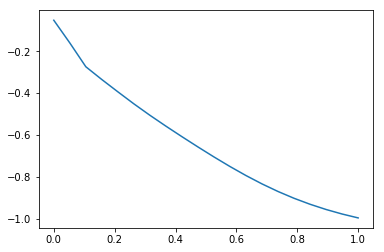

In [4]:
%%time
tf.reset_default_graph()

#debug = False  # No debuging.

x_dim = 1
n_samples = 20
y_dim = 1

with tf.name_scope('X'):
    x_within = tf.placeholder(shape=[n_samples, x_dim], dtype='float32',
                              name='x_within')
    x_boundary = tf.constant([[0.0], [1.0]], dtype='float32',
                             name='x_boundary')
    
with tf.name_scope('HiddenLayers'):
    hidden_layers = []
    for i in range(3):
        hidden_layers += [
            lambda x: tf.layers.dense(
                x, 10, activation=tf.nn.sigmoid),
            lambda x: tf.layers.dropout(x),
        ]
ops = make_loss(
    x_within, x_boundary,
    lambda x: make_neural_network(x, hidden_layers, [y_dim]))

# For optimizing
optimizer = tf.train.AdamOptimizer(0.01)
train_op = optimizer.minimize(ops.loss)


# For logging
tf.summary.scalar('loss', ops.loss)
summary_op = tf.summary.merge_all()

sess = tf.InteractiveSession()

# -- Initializing
# For logging
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
writer = tf.summary.FileWriter('./logdir/'+ current_time, sess.graph)
# Initialize all `tf.Variable`s, explicit or implicit
sess.run(tf.global_variables_initializer())

# -- Optimizing

# Parameters
n_iters = 3*10**4

def get_x_within_value():
    x_within_value = np.array(
        [[np.random.random()] for _ in range(n_samples)],
        dtype='float32')
    return x_within_value

# Iterations
for step in range(n_iters):
    iter_ops = [train_op, summary_op, ops.loss, ops.y,
                ops.grad_y, ops.action_part, ops.boundary_part]
    feed_dict = {x_within: get_x_within_value()}
    # No debugging
    result = sess.run(iter_ops, feed_dict=feed_dict)
    _, summary, loss, y, grad_y, action_part, boundary_part = result
    '''
    # Otherwise
    if debug:
        # Use `tdb`
        if (step+1) % 10 == 0:
            # Visualize
            status, result = tdb.debug(
                iter_ops, feed_dict=feed_dict, session=sess,
                breakpoints=None, break_immediately=False)
        else:
            status, result = tdb.debug(
                iter_ops, feed_dict=feed_dict, session=sess)
            
    else:
        result = sess.run(iter_ops, feed_dict=feed_dict)
    '''
    if (step+1) % 100 == 0:
        writer.add_summary(summary, step)
        print(step, loss, action_part, boundary_part,
              l1_norm(grad_y), l1_norm(y))

# Return the predict-values of the trained neural network
x_within_value = np.linspace(0, 1, n_samples, dtype='float32')
x_within_value = np.expand_dims(x_within_value, axis=1)
y_within_value = sess.run(
    ops.y_within,
    feed_dict={x_within: x_within_value})

sess.close()

plt.plot(x_within_value, y_within_value)